# Testing Environment
This notebook somewhat streamlines the testing process. Creation of a ModelTest object automatically runs tests and reports the results after initial configurations are set.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20*.75, 10*.75)
plt.rcParams['font.size'] = 20*.75
plt.rcParams['axes.titlesize'] = 30*.75
plt.rcParams['axes.labelsize'] = 20*.75
plt.rcParams['xtick.labelsize'] = 20*.75
plt.rcParams['ytick.labelsize'] = 20*.75


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


simple_multi_dataset = pd.read_csv('simple_multi_dataset.csv')
# Change below in order to adjust the bin size
vel_and_gyro = pd.read_csv('velocity_and_gyro_binned_1s.csv')
vel_and_gyro = vel_and_gyro.drop(columns='Unnamed: 0')

simple_multi_with_windows = pd.concat([simple_multi_dataset,vel_and_gyro],axis=1)

In [2]:
class ModelTest:
    """
    Creates an instance of a test using Smartfin IMU data. Things like the model, the data used,
    whether or not to balance/scale the data, and other parameters are included so as to streamline the testing
    process.
    """
    def __init__(self,model='MLP',data=simple_multi_with_windows,use_balanced_data=False,scale_data=True):
        """
        model: String, should be either 'MLP' or 'SVM' for now
        
        data: a dataframe consisting of IMU data and some labels. For now, the default and only supported type of
              data is simple_multi_with_windows, defined in the cell above.
              
        use_balanced_data: Boolean, 'True' to balance the training set, 'False' to leave the data unbalanced
        
        scale_data: Boolean, 'True' to scale all features, 'False' to leave them unscaled
        """
        self.model = model
        self.data = data
        self.use_balanced_data = use_balanced_data
        self.scale_data = scale_data
        self.setUp()
        
    def set_data(d):
        self.data = d
        
    def set_model(m):
        self.model = m
        
    def set_use_balanced_data(b):
        self.use_balanced_data = b
    
    def set_scale_data(s):
        self.scale_data = s
        
    def setUp(self):

        print("Setting up test...")
        print("Separating features and labels within the dataset...")
        self.X = self.data.drop(columns='simple_label',axis=1).iloc[:, 2:-1].values
        self.y = self.data['simple_label'].values   #selects the last column 
        print("X.shape:", self.X.shape)
        print("y.shape:", self.y.shape)
        print("y:", self.y)

        print("*"*50)
        
        print("Splitting data into training and test sets...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.1, random_state = 0)
        
        print("X_train shape:", self.X_train.shape)
        print("y_train shape:", self.y_train.shape)
        print("X_test shape:", self.X_test.shape)
        print("y_test shape:", self.y_test.shape)
        
        if self.scale_data:
            print("Scaling data...")
            scaler = StandardScaler()
            scaler.fit(self.X_train)
            self.X_train = scaler.transform(self.X_train)
            self.X_test = scaler.transform(self.X_test)
        
        if self.use_balanced_data:
            print("Balancing training set...")
            self.X_train, self.y_train = SMOTE().fit_resample(self.X_train, self.y_train)
            print("X_train shape:", self.X_train.shape)
            print("y_train shape:", self.y_train.shape)
            
        
        print("Training model...")
        
        if self.model == 'MLP':
            self.clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,15), random_state=1, verbose=True)
            self.clf.fit(self.X_train, self.y_train)
        elif self.model == 'SVM':
            self.clf = SVC(kernel='linear')  
            self.clf.fit(self.X_train, self.y_train) 
            #Making predictions: use the predict method of the SVC class
            self.y_pred = self.clf.predict(self.X_test)
        else:
            print("Specified model is invalid: use 'set_model()' to specify a valid model.\nSupported models are 'SVM' and 'MLP'")
        
        self.y_pred = self.clf.predict(self.X_test)
        self.runTest()
        
    def runTest(self):
        print("Running test...")
        
        self.cm = confusion_matrix(y_true=self.y_test, y_pred=self.y_pred, labels=["FLOATING", "PADDLING", "SURFING"])
#         plt.figure()
#         plt.grid('off')

        #plot_confusion_matrix(self.cm, classes=class_names,
                              #title='Multinomial Confusion Matrix')

        # Plot normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(self.cm, classes=class_names, normalize=True,
                              title='Normalized Multinomial Confusion Matrix')
        
        # cross validation score
        score = cross_val_score(estimator = self.clf, X = self.X, y = self.y, cv = 10)
        print(score)
        print('Average cross validation score: ', np.mean(score))
        print('Median cross validation score: ', np.median(score))
        print('Standard Deviation of cross validation scores: ', np.sqrt(np.var(score)))
        print('\n\n')

# MLP Test
Below are tests run on an MLP using unbalanced training data and a range of bin sizes.

Bin size:  1 s
Setting up test...
Separating features and labels within the dataset...
X.shape: (6688, 20)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
**************************************************
Splitting data into training and test sets...
X_train shape: (6019, 20)
y_train shape: (6019,)
X_test shape: (669, 20)
y_test shape: (669,)
Scaling data...
Training model...
Running test...
Multinomial LR normalized confusion matrix
[[0.88405797 0.11111111 0.00483092]
 [0.34782609 0.64347826 0.00869565]
 [0.56       0.2        0.24      ]]
[0.56716418 0.90447761 0.66068759 0.65321375 0.82959641 0.79073244
 0.79041916 0.71257485 0.40419162 0.45359281]
Average cross validation score:  0.6766650428478429
Median cross validation score:  0.6866312218612103
Standard Deviation of cross validation scores:  0.15470168800780612



Bin size  1  completed
Bin size:  2 s
Setting up test...
Separating features and labels within the dataset...
X.shape: (6688

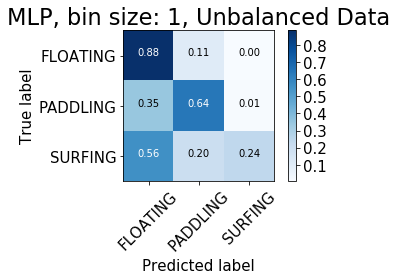

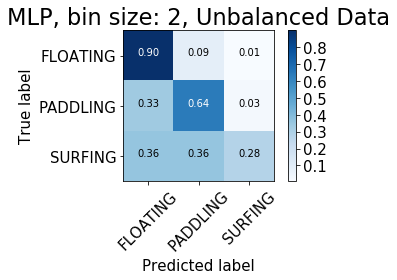

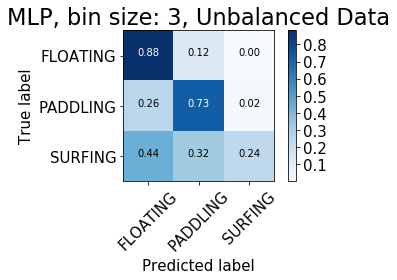

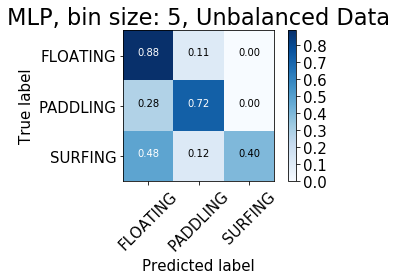

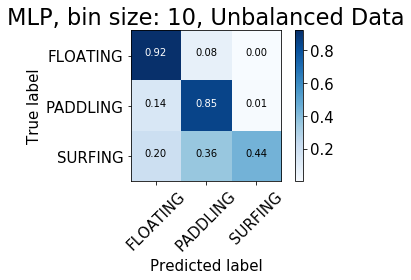

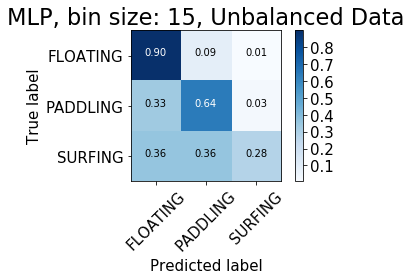

In [3]:
simple_multi_dataset = pd.read_csv('simple_multi_dataset.csv')

# Specifies the bin size
for i in [1,2,3,5,10,15]:
    print('Bin size: ', str(i),'s')
    fname = 'velocity_and_gyro_binned_' + str(i) + 's.csv'
    vel_and_gyro = pd.read_csv(fname)
    vel_and_gyro = vel_and_gyro.drop(columns='Unnamed: 0')
    simple_multi_with_windows = pd.concat([simple_multi_dataset,vel_and_gyro],axis=1)
    MLP_test1=ModelTest(model='MLP',data=simple_multi_with_windows,use_balanced_data=False,scale_data=True)
    print('Bin size ', i ,' completed')
    plt.title('MLP, bin size: ' + str(i) + ', Unbalanced Data')

Below are the same MLP tests, except the training data is now balanced using SMOTE.

Bin size:  1 s
Setting up test...
Separating features and labels within the dataset...
X.shape: (6688, 20)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
**************************************************
Splitting data into training and test sets...
X_train shape: (6019, 20)
y_train shape: (6019,)
X_test shape: (669, 20)
y_test shape: (669,)
Scaling data...
Balancing training set...
X_train shape: (11694, 20)
y_train shape: (11694,)
Training model...
Running test...
Multinomial LR normalized confusion matrix
[[0.7705314  0.1884058  0.0410628 ]
 [0.25652174 0.69565217 0.04782609]
 [0.24       0.12       0.64      ]]
[0.56716418 0.90447761 0.66068759 0.65321375 0.82959641 0.79073244
 0.79041916 0.71257485 0.40419162 0.45359281]
Average cross validation score:  0.6766650428478429
Median cross validation score:  0.6866312218612103
Standard Deviation of cross validation scores:  0.15470168800780612



Bin size  1  completed
Bin size:  2 s
Setting u

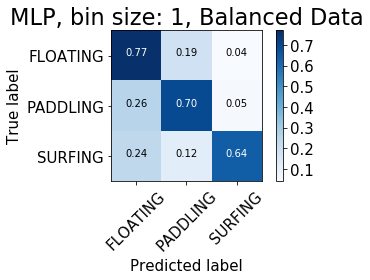

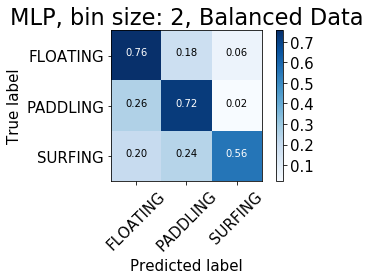

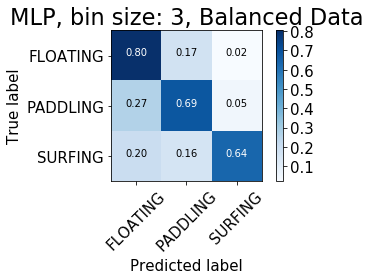

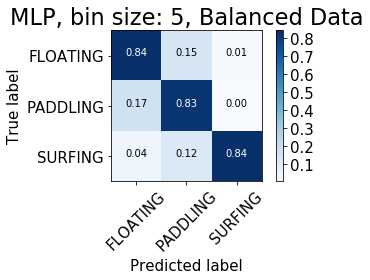

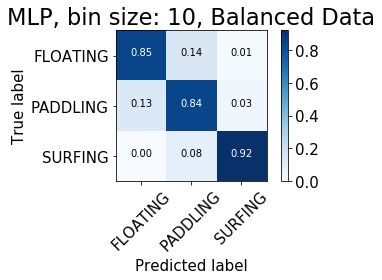

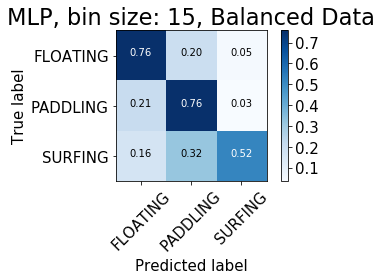

In [4]:
for i in [1,2,3,5,10,15]:
    print('Bin size: ', str(i),'s')
    fname = 'velocity_and_gyro_binned_' + str(i) + 's.csv'
    vel_and_gyro = pd.read_csv(fname)
    vel_and_gyro = vel_and_gyro.drop(columns='Unnamed: 0')
    simple_multi_with_windows = pd.concat([simple_multi_dataset,vel_and_gyro],axis=1)
    MLP_test1=ModelTest(model='MLP',data=simple_multi_with_windows,use_balanced_data=True,scale_data=True)
    print('Bin size ', i ,' completed')
    plt.title('MLP, bin size: ' + str(i) + ', Balanced Data')

Below are the SVM tests using unbalanced data:

Bin size:  1 s
Setting up test...
Separating features and labels within the dataset...
X.shape: (6688, 20)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
**************************************************
Splitting data into training and test sets...
X_train shape: (6019, 20)
y_train shape: (6019,)
X_test shape: (669, 20)
y_test shape: (669,)
Scaling data...
Training model...
Running test...
Multinomial LR normalized confusion matrix
[[0.91062802 0.08937198 0.        ]
 [0.5        0.5        0.        ]
 [0.8        0.2        0.        ]]
[0.5358209  0.88656716 0.754858   0.73542601 0.8445441  0.81016442
 0.76646707 0.81886228 0.51497006 0.38622754]
Average cross validation score:  0.7053907531967722
Median cross validation score:  0.7606625314393635
Standard Deviation of cross validation scores:  0.15811401726227803



Bin size  1  completed
Bin size:  2 s
Setting up test...
Separating features and labels within the dataset...
X.shape: (6688

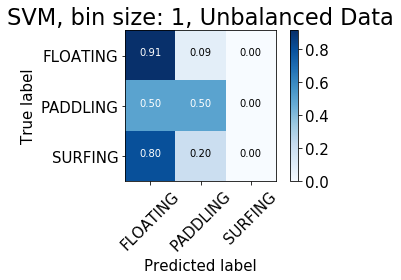

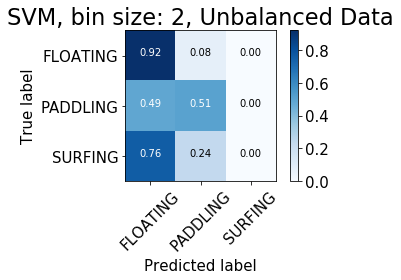

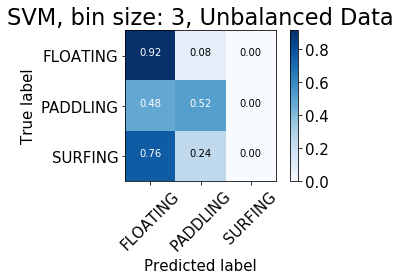

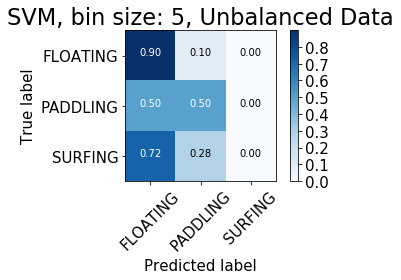

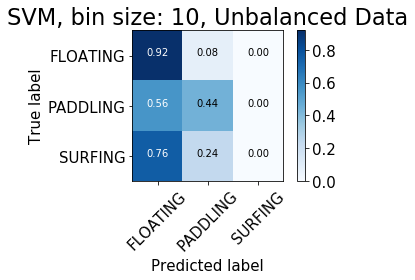

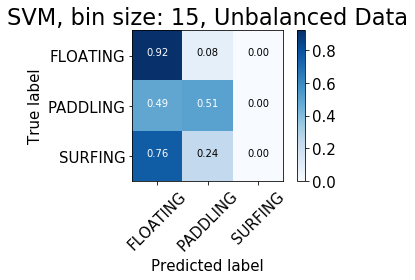

In [5]:
for i in [1,2,3,5,10,15]:
    print('Bin size: ', str(i),'s')
    fname = 'velocity_and_gyro_binned_' + str(i) + 's.csv'
    vel_and_gyro = pd.read_csv(fname)
    vel_and_gyro = vel_and_gyro.drop(columns='Unnamed: 0')
    simple_multi_with_windows = pd.concat([simple_multi_dataset,vel_and_gyro],axis=1)
    MLP_test1=ModelTest(model='SVM',data=simple_multi_with_windows,use_balanced_data=False,scale_data=True)
    print('Bin size ', i ,' completed')
    plt.title('SVM, bin size: ' + str(i) + ', Unbalanced Data')

Finally, the SVM tests with balanced training data are shown below:

Bin size:  1 s
Setting up test...
Separating features and labels within the dataset...
X.shape: (6688, 20)
y.shape: (6688,)
y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'SURFING' 'SURFING' 'SURFING']
**************************************************
Splitting data into training and test sets...
X_train shape: (6019, 20)
y_train shape: (6019,)
X_test shape: (669, 20)
y_test shape: (669,)
Scaling data...
Balancing training set...
X_train shape: (11694, 20)
y_train shape: (11694,)
Training model...
Running test...
Multinomial LR normalized confusion matrix
[[0.49758454 0.17874396 0.3236715 ]
 [0.15217391 0.6173913  0.23043478]
 [0.16       0.04       0.8       ]]
[0.5358209  0.88656716 0.754858   0.73542601 0.8445441  0.81016442
 0.76646707 0.81886228 0.51497006 0.38622754]
Average cross validation score:  0.7053907531967722
Median cross validation score:  0.7606625314393635
Standard Deviation of cross validation scores:  0.15811401726227803



Bin size  1  completed
Bin size:  2 s
Setting u

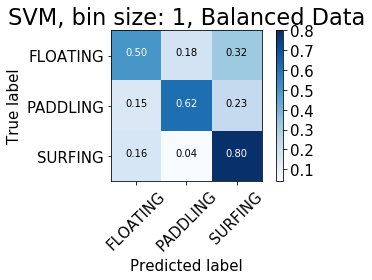

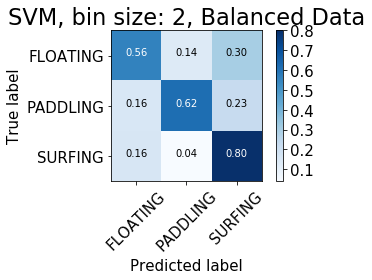

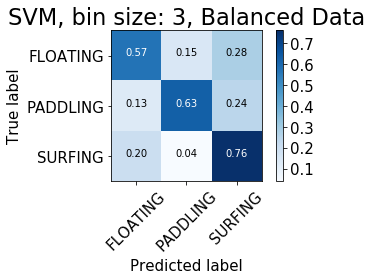

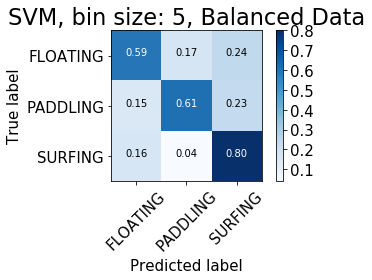

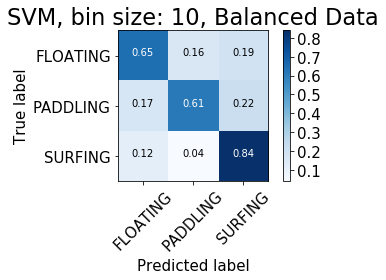

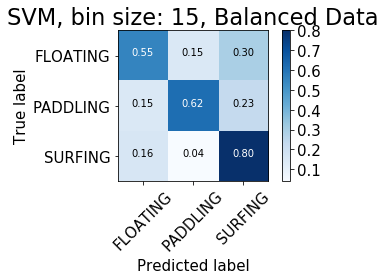

In [6]:
for i in [1,2,3,5,10,15]:
    print('Bin size: ', str(i),'s')
    fname = 'velocity_and_gyro_binned_' + str(i) + 's.csv'
    vel_and_gyro = pd.read_csv(fname)
    vel_and_gyro = vel_and_gyro.drop(columns='Unnamed: 0')
    simple_multi_with_windows = pd.concat([simple_multi_dataset,vel_and_gyro],axis=1)
    MLP_test1=ModelTest(model='SVM',data=simple_multi_with_windows,use_balanced_data=True,scale_data=True)
    print('Bin size ', i ,' completed')
    plt.title('SVM, bin size: ' + str(i) + ', Balanced Data')